# A. Establish Preliminary Results

## Imports packages 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import pearsonr

from category_encoders import MEstimateEncoder, CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer

from datetime import datetime

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set()

## Data Preprocessing
### Import Data

In [2]:
# Train data
df_train = pd.read_csv("train.csv", index_col="Id")
print(df_train.shape)

# Test data
df_test = pd.read_csv("test.csv", index_col="Id")
print(df_test.shape)

(1460, 80)
(1459, 79)


In [3]:
pd.set_option('display.max_columns', None) 
df_train.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


### Merge train and test data

In [4]:
y = df_train.pop('SalePrice')
df_merged = pd.concat([df_train, df_test])
print(df_merged.shape)
df_merged.head(2)

(2919, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal


### Find missing values

<AxesSubplot:>

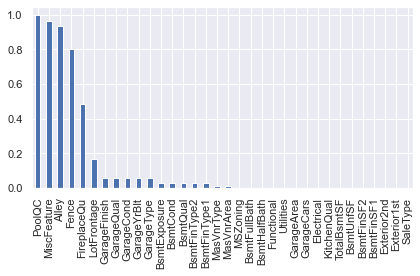

In [5]:
# Only show columns containing NAs and the corresponding counts in percentage
df_missing = df_merged.isna().sum()[df_merged.isna().sum() > 0].sort_values(ascending = False)/len(df_merged)
df_missing.plot.bar()

### Clean Data

Rename some of the categorical features as per the information in data_description.txt

In [6]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df


### Encode the statistical data type

In [7]:
# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", 
                "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", 
                "SaleCondition"]


# The ordinal (ordered) categorical features 
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"] # poor, fair, typical, good, excellent
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a new level 'None' in each ordinal categorical feature for handling missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()} 

def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category") 
        # Add a 'None' category for missing values
        if "None" not in df[name].cat.categories: 
            df[name] = df[name].cat.add_categories("None")
            
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))  
    return df


### Perform preprocessing

In [8]:
def process_data(df):
    df = clean(df)
    df = encode(df)
    return df

df_merged = process_data(df_merged)

### Handle Missing Values

In [9]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None") # We made a new category 'None' during encoding so we can fill 'NA' with 'None' 
    return df


### Impute missing values

In [10]:
df_merged = impute(df_merged)

In [11]:
# Chech if there are still any missing values!
df_merged.isna().sum()[df_merged.isna().sum() > 0].sort_values(ascending = False)

Series([], dtype: int64)

### Visualise the relation between numerical features and SalePrice

In [12]:
df_train = df_merged.loc[y.index, :]
df_train = df_train.join(y)

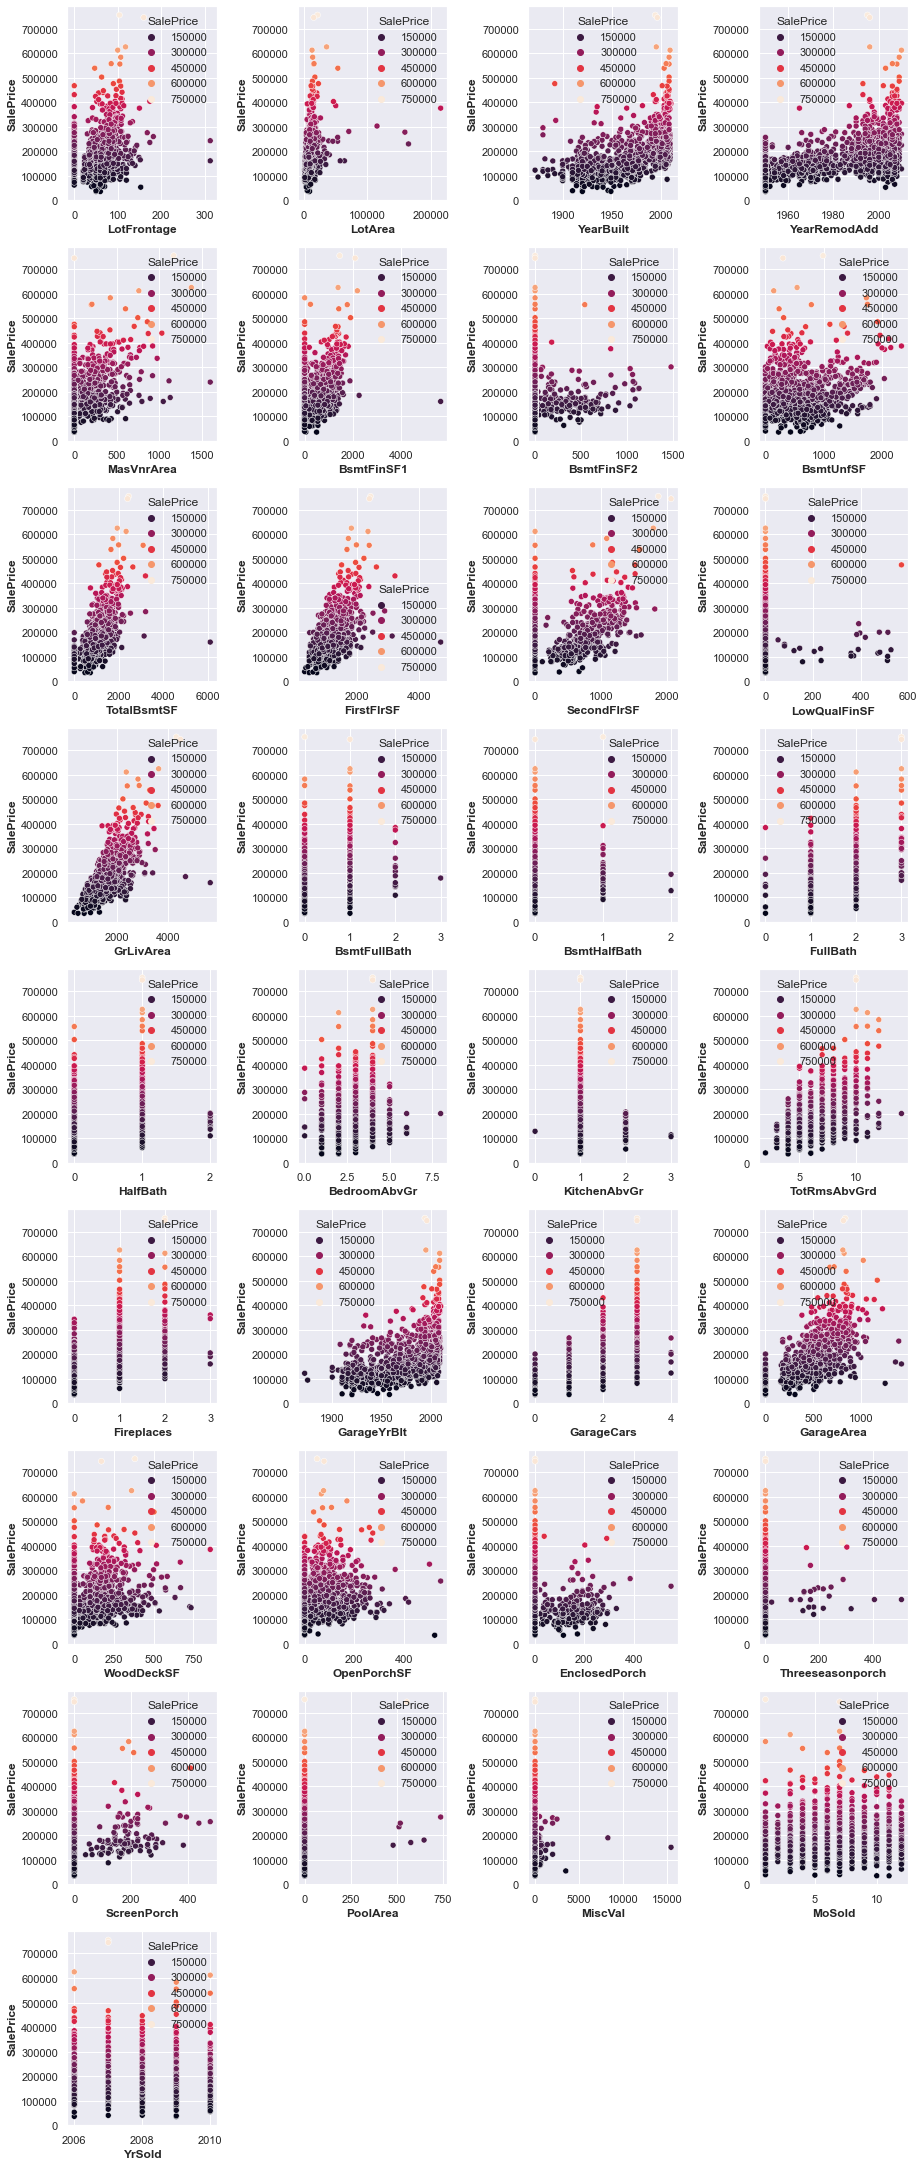

In [13]:
numeric_cols = []
for name in df_train.drop('SalePrice', axis =1).select_dtypes("number"):
    numeric_cols.append(name)
    
fig, axs = plt.subplots( figsize=(13, 110))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 4, i)
    sns.scatterplot(x=col, y='SalePrice', hue='SalePrice', palette="rocket", data=df_train)

## Establish Baseline Score

In [14]:
def score_dataset(X, y, model=XGBRegressor()):
    # The `cat.codes` attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes # label encode categorical columns
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log1p(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [15]:
%%time
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14309 RMSLE
CPU times: total: 5.62 s
Wall time: 1.45 s


# B. Feature Engineering

## Mutual Information Score

In [16]:
def make_mi_scores(X, y):
    X = X.copy()
    #for colname in X.select_dtypes(["object", "category"]):
    for colname in X.select_dtypes(["category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes] 
    # defining all the integer (numeric) data types as discrete
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Let's look at our feature scores again:

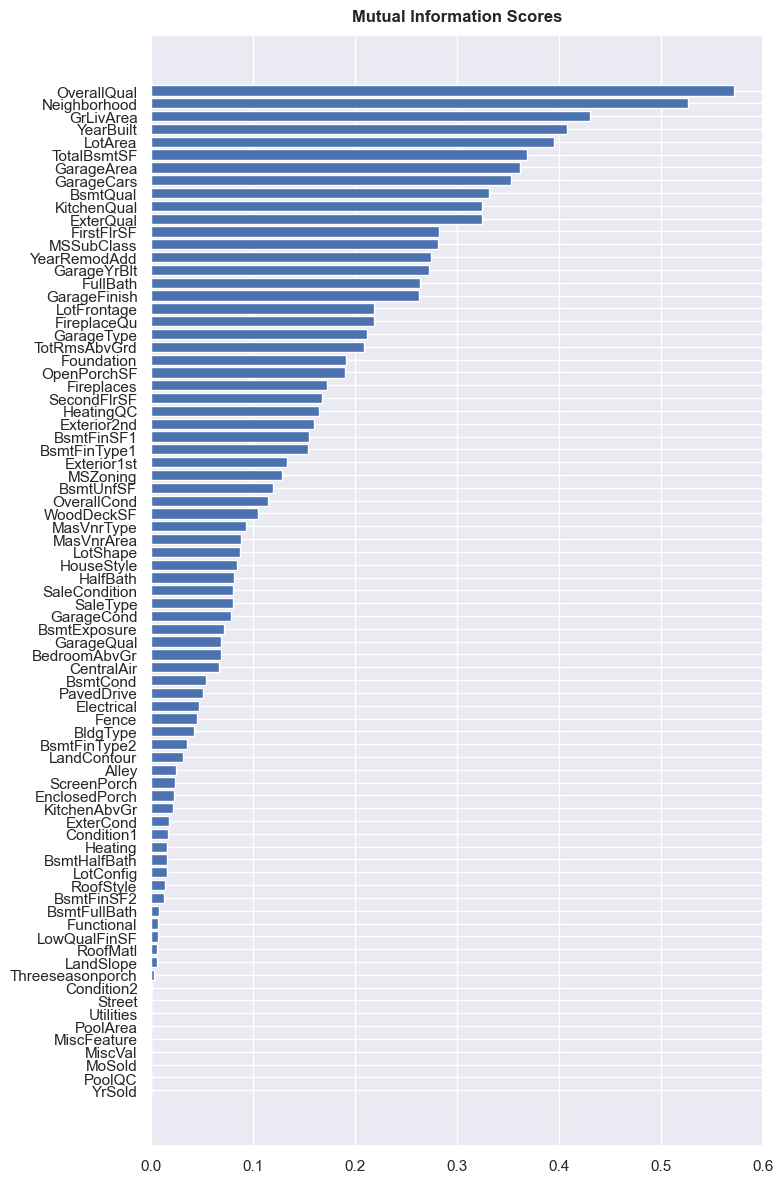

In [17]:
mi_scores = make_mi_scores(X, y) 
plt.figure(dpi=100, figsize=(8, 12))
plot_mi_scores(mi_scores)

Training on uninformative features can lead to overfitting. So, we'll drop entirely the features with scores equal or very close to 0.0 at the final stage of the model development.

In [18]:
mi_zero = mi_scores[mi_scores == 0].index.tolist() # a list of the columns with mi_scores = 0
mi_zero

['PoolQC', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold']

In [19]:
def drop_uninformative(df):
    df = df.drop(mi_zero, axis =1)
    return df

# C. Feature Engineering

## Create Features with Pandas

In [20]:
def create_features_pandas(df):
    
    X = df.copy()
    # mathematical_transforms:
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    X['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
    X['TotalSF'] = df['TotalBsmtSF'] + df['FirstFlrSF'] + df['SecondFlrSF']

    X['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                                 df['FirstFlrSF'] + df['SecondFlrSF'])

    X['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    
    X['Total_porch_sf'] = (df['OpenPorchSF'] + df['Threeseasonporch'] + df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])
    
        
    X['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0) # Increases LB Score to 0.11993 (position 195) 
                                                                     # from  0.12072 (position 281)!                                                                         
    X['has2ndfloor'] = df['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


    # interaction features
    X1 = pd.get_dummies(df.BldgType, prefix="Bldg")
    X1 = X1.mul(df.GrLivArea, axis=0)
    
    X2 = pd.get_dummies(df.Neighborhood, prefix="Neighbhd")
    X2 = X2.mul(df.GrLivArea, axis=0)
    
    X = X.join(X1)
    X = X.join(X2)
       
    
    # counts features
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)


    # group_transforms features
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    
    
    return X


In [21]:
df_merged = create_features_pandas(df_merged)

In [22]:
df_train = df_merged.loc[y.index, :]

score = score_dataset(df_train, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13799 RMSLE


## Principal Component Analysis

In [23]:
# Fit scikit-learn's PCA estimator and create the principal components
def apply_pca(X, standardize=True):
    # Standardize the data when the selected features aren't naturally on the same scale.
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  
        columns=component_names,  
        index=X.columns,  
    )
    return pca, X_pca, loadings


# Plot the variation captured by the the signs and magnitudes of a component's loadings
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [24]:
pca_features = [
    'GarageArea',
    'YearRemodAdd',
    'TotalBsmtSF',
    'GrLivArea',
]

X = df_train.copy()
X = X.loc[:, pca_features]

pca, X_pca, loadings = apply_pca(X)
loadings

,PC1,PC2,PC3,PC4
GarageArea,0.542671,0.055849,0.172729,-0.820094
YearRemodAdd,0.418537,-0.883023,-0.052628,0.205735
TotalBsmtSF,0.518308,0.324224,0.617357,0.495082
GrLivArea,0.511558,0.334709,-0.765680,0.200032


In [25]:
mi_scores = make_mi_scores(X_pca, y)
mi_scores

PC1    0.830680
PC2    0.225699
PC3    0.178745
PC4    0.051648
Name: MI Scores, dtype: float64

**A correlation matrix for the dataset can help finding new features! We can search for highly correlated features and apply PCA.**

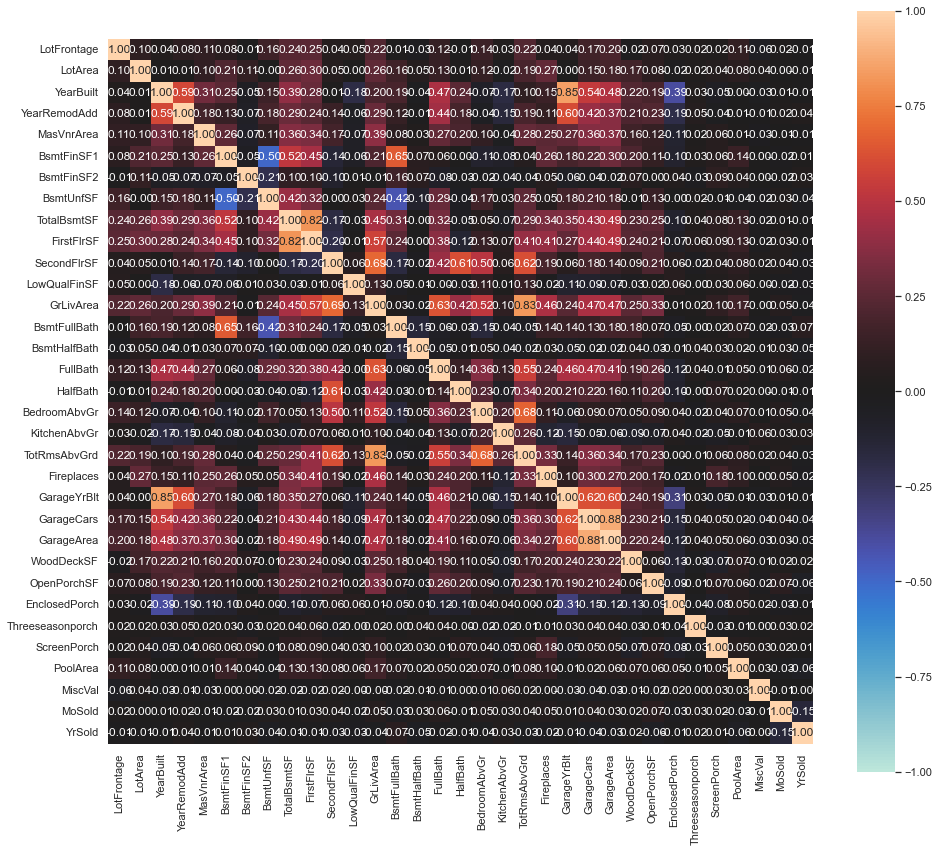

In [26]:
def corrplot(df, method="pearson"):
    corr = df.corr(method)
    plt.subplots(figsize=(14,12))
    sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="icefire", square=True, annot=True, fmt=".2f") # cmap="Blues"   
    
df_train = df_merged.loc[y.index, :]    
corrplot(df_train[numeric_cols], method="pearson")

In [27]:
pca_features2 = ['FullBath',
    'FirstFlrSF',
    'SecondFlrSF',
    'TotRmsAbvGrd',
    'GarageCars',
    'GarageArea',
    'GrLivArea',
]

X = df_train.copy()
X = X.loc[:, pca_features2]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca2, X_pca2, loadings2 = apply_pca(X)
loadings2

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
FullBath,0.388377,0.089598,0.057532,-0.909435,-0.036068,0.097151,0.003819
FirstFlrSF,0.310710,-0.420994,0.635974,0.110642,0.241857,-0.085545,-0.493666
SecondFlrSF,0.284178,0.612029,-0.321452,0.142251,0.329827,-0.034139,-0.557803
TotRmsAbvGrd,0.415006,0.290409,0.244309,0.261620,-0.779330,0.088544,-0.010238
GarageCars,0.379841,-0.372442,-0.463272,0.028345,-0.150992,-0.691836,0.012131
GarageArea,0.371316,-0.416292,-0.411836,0.164349,0.048228,0.699909,-0.002663
GrLivArea,0.466348,0.209301,0.212081,0.210219,0.446025,-0.075685,0.666990


In [28]:
mi_scores2 = make_mi_scores(X_pca2, y)
mi_scores2

PC1    0.667084
PC4    0.276402
PC2    0.227001
PC7    0.165142
PC6    0.054360
PC3    0.052895
PC5    0.052686
Name: MI Scores, dtype: float64

In [29]:
# Create New Features inspired by the loadings of the principal components
def pca_inspired(df):
    X = df.copy()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF 
    X["Feature2"] = np.sqrt(df.YearRemodAdd * df.TotalBsmtSF)
    X["Feature3"] = df.GrLivArea * df.TotRmsAbvGrd 
    X["Feature4"] = np.sqrt(df.GrLivArea * df.FirstFlrSF)
    X["Feature5"] = np.sqrt(df.GarageCars * df.GarageArea)
    X["Feature6"] = np.sqrt(df.GrLivArea * df.FullBath)
    X["Feature7"] = np.sqrt(df.GrLivArea * df.SecondFlrSF)
   
    return X

# df_merged = pca_inspired(df_merged)
# df_train = df_merged.loc[y.index, :]

# score = score_dataset(df_train, y)
# print(f"Score (CV): {score:.5f} RMSLE")

## Drop uninformative features
As we are near the final stages of feature engineering, we can drop the uninformative features we'he found through mutual information score analysis.

In [30]:
df_merged = drop_uninformative(df_merged)
df_train = df_merged.loc[y.index, :]

score = score_dataset(df_train, y)
print(f"Score (CV): {score:.5f} RMSLE")

Score (CV): 0.13455 RMSLE


## Target Encoding
### Encode Categorical Features and split to train and test sets
Create a function for label encoding categorical features

In [31]:
def label_encode(df):
    X = df.copy()
    # The `cat.codes` attribute holds the category levels.
    for colname in X.select_dtypes(["category"]).columns:
        X[colname] = X[colname].cat.codes
    return X


Let's create another function for one-hot encoding for the categorical features. 

In [32]:
def one_hot_encode(df):
    X = df.copy()
    X = pd.get_dummies(X)
    return X

In [33]:
df_merged = label_encode(df_merged)

df_train = df_merged.loc[y.index, :]
df_train  = df_train.join(y)
df_test = df_merged.loc[df_test.index, :]

In [34]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


In [35]:
X_train = df_train.copy()
y_train = X_train.pop("SalePrice")

X_test = df_test

In [36]:
# encode_features = ['MSSubClass','Neighborhood']
# encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
# X_train = X_train.join(encoder.fit_transform(X_train, y_train, cols=['MSSubClass'])) 
# X_test = X_test.join(encoder.transform(X_test))

### Calculate the score again

In [37]:
score = score_dataset(X_train, y_train)
print(f"Score (CV): {score:.10f} RMSLE")

Score (CV): 0.1345516469 RMSLE


### Root Mean Squared Logaritmic Error (RMSLE)

In [38]:
# defining kfolds for cross-validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def score_rmsle(X, y, model):
    score = -cross_val_score(model, X, np.log1p(y), cv=kfolds, scoring="neg_mean_squared_error")
    score = score.mean()
    score = np.sqrt(score)
    return score

# D. Hyperparameter Tuning
The follwoing hyperparametrs were achieved with tuning through Optuna.

In [39]:
xgb_params = dict(max_depth=4,  
                  learning_rate=0.0053462077,    
                  n_estimators=7453,     
                  min_child_weight=2,    
                  colsample_bytree=0.3303411,  
                  subsample= 0.3027622,         
                  reg_alpha=0.00033631,         
                  reg_lambda=0.002343958,
                  num_parallel_tree=1
                  )

xgb =  XGBRegressor(**xgb_params)

In [40]:
%%time

# Recalculate score with the optimal parameters obtained with Optuna 

score_xgb = score_rmsle(X_train, y_train, xgb)
print("xgboost: {:.5f}".format(score_xgb))

xgboost: 0.11345
CPU times: total: 6min 23s
Wall time: 2min 24s


# E. Train Model and Create Submission

In [41]:
# XGB minimizes MSE, but competition loss is RMSLE, so log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y_train))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
print(output.head())

Your submission was successfully saved!
     Id      SalePrice
0  1461  128645.312500
1  1462  163030.843750
2  1463  190030.265625
3  1464  195908.843750
4  1465  187618.718750
